In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from train_mnist import MnistMultiTask,label_remaps_dict,load_clip_features,Mlp
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm,tqdm_notebook
from torch import nn
import numpy as np
import torchvision.transforms as T
import torch
from tqdm import tqdm, trange
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from tqdm import tqdm, tqdm_notebook
import torch.nn.functional as F
import matplotlib.pylab as plt
import matplotlib.tri as tri
import pickle as pkl
from copy import deepcopy
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from torch.cuda.amp import autocast

device="cuda"
batch_size = 500
repeat_number = 5
num_classes = 512
num_worker=8
test_trans = T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)])
datadir = "./data"
ds = MnistMultiTask(MNIST(datadir,
                                       train=False,
                                       transform=test_trans),
                                 tasks=["prime","odd"])
task_class_name = {
    "prime": ["non-prime", "prime"],
    "odd": ["even", "odd"],
    "normal": ["one", "two", "three", "four", "five", "six", "eight", "nine"]
}

def get_mlp_perm():
    return {
        0: [
            [0, "fc1.weight"],
            [1, "fc2.weight", {
                "in": None
            }],
        ],
        1: [
            [0, "fc2.weight"],
            [1, "fc3.weight", {
                "in": None
            }],
        ],
        2: [
            [0, "fc3.weight"],
            [1, "fc4.weight", {
                "in": None
            }],
        ],
    }


dl = DataLoader(ds,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_worker)
task1_dir = "checkpoints/mnist_clip/prime"
task2_dir = "checkpoints/mnist_clip/odd"
exp_idx = 4

prime_class_vectors = load_clip_features(task_class_name["prime"])
odd_class_vectors = load_clip_features(task_class_name["odd"])
@torch.no_grad()
@autocast()
def test_network(net:nn.Module):
    net.eval().to(device)
    loss1 = 0
    loss2 = 0
    acc1 = 0
    acc2 = 0
    loss_func = nn.CrossEntropyLoss()
    # for img,labels in tqdm(dl,total=len(dl),desc="Testing"):
    for img,labels in dl:
        img = img.to(device).reshape(img.shape[0],-1)
        label1 = labels[0].to(device)
        label2 = labels[1].to(device)
        encodings = net(img)
        normed_encodings = encodings / encodings.norm(dim=-1,
                                                                  keepdim=True)

        logits1 = (100.0 * normed_encodings @ prime_class_vectors.T)
        logits2 = (100.0 * normed_encodings @ odd_class_vectors.T)
        loss1 += loss_func(logits1,label1).cpu().detach().item() * img.shape[0]
        loss2 += loss_func(logits2,label2).cpu().detach().item() * img.shape[0]
        acc1 += (logits1.argmax(dim=1).data == label1).sum().cpu().detach().item()
        acc2 += (logits2.argmax(dim=1).data == label2).sum().cpu().detach().item()
    
    result = {"loss1":loss1,"loss2":loss2,"acc1":acc1,"acc2":acc2}

    result = {k:v/len(ds) for k,v in result.items()}
    return result

class MNISTActDataset(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.ds = MNIST(datadir,
                                  train=True,
                                  transform=test_trans)
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, index):
        img,label = self.ds[index]
        return img.reshape(-1),label
        
    
act_ds = MNISTActDataset()
act_dl = DataLoader(act_ds,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_worker)

neta_state = torch.load(os.path.join(f"{task1_dir}/{exp_idx}/best.pth"),map_location=device)
netb_state = torch.load(os.path.join(f"{task2_dir}/{(exp_idx+1)%5}/best.pth"),map_location=device)



model_keys = ["fc1.weight","fc2.weight","fc3.weight","fc4.weight"]
def get_1d_weight(net):
    if isinstance(net,nn.Module):
        net = net.state_dict()
    
    para = []
    for kk in model_keys:
        vv = net[kk]
        para.append(vv.flatten())
    return torch.cat(para)

def test_merged(state_merged):
    state_merged = deepcopy(state_merged)
    net_ = Mlp(out_features=num_classes)
    net_.load_state_dict(state_merged)
    return test_network(net_)

In [2]:

param = get_1d_weight(deepcopy(neta_state))
param.shape

torch.Size([3424256])

In [3]:
def vec2net(para):
    sdict, left = {}, 0
    net = Mlp(out_features=num_classes)
    for kk, vv in net.state_dict().items():
        num = vv.numel()
        sdict[kk] = para[left:left+num].view(vv.shape)
        left += num
    net.load_state_dict(sdict)
    net.to(device)
    return net

param = get_1d_weight(deepcopy(neta_state))
neta = vec2net(param)
param = get_1d_weight(deepcopy(netb_state))
netb = vec2net(param)
test_network(neta),test_network(netb)


({'loss1': 0.03403312081936747,
  'loss2': 0.7417371094226837,
  'acc1': 0.9872,
  'acc2': 0.436},
 {'loss1': 0.9998829185962677,
  'loss2': 0.03771120090968907,
  'acc1': 0.3366,
  'acc2': 0.9881})

In [4]:
use_permute = False

In [5]:
base_nets = []
# avg_rates = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
avg_rates = [0,0.5,1]

## Activation based merge

In [6]:
from mudsc import WeightFusion
perm = get_mlp_perm()
neta = Mlp(out_features=num_classes)
netb = Mlp(out_features=num_classes)
net_root = Mlp(out_features=num_classes)
neta.load_state_dict(deepcopy(neta_state))
netb.load_state_dict(deepcopy(netb_state))
neta.to(device)
netb.to(device)
net_root.to(device)
state_merge = WeightFusion(use_permute=use_permute).transform([neta,netb],perm,act_loader=act_dl,return_state_dict=True)
net_root.load_state_dict({k:v[0] for k,v in  state_merge.items()})
for r in avg_rates:
    state_merge_ = {k:v[0]*r+v[1]*(1-r)  for k,v in state_merge.items()}
    base_nets.append(state_merge_)
test_merged(base_nets[-2])

Computing permutation: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


{'loss1': 0.106729856133461,
 'loss2': 0.14129881635308267,
 'acc1': 0.9722,
 'acc2': 0.9518}

## Weight based merge

In [7]:
from mudsc import WeightFusion
perm = get_mlp_perm()
neta = Mlp(out_features=num_classes)
netb = Mlp(out_features=num_classes)
neta.load_state_dict(deepcopy(neta_state))
netb.load_state_dict(deepcopy(netb_state))
neta.to(device)
netb.to(device)
state_merge = WeightFusion(verbose=True,use_permute=use_permute).transform([neta,netb],perm,return_state_dict=True)

neta.load_state_dict({k:v[0] for k,v in state_merge.items()})
netb.load_state_dict({k:v[1] for k,v in state_merge.items()})
# Align model A with the activation-based method for the closer basins
align_fusion = WeightFusion(verbose=True,use_permute=True)
state_align_a = align_fusion.transform([net_root,neta],perm,return_state_dict=True)
state_align_a = {k:v[1] for k,v in state_align_a.items()}
state_align_b = align_fusion.apply_permute([net_root.state_dict(),netb.state_dict()],no_avg=True)
state_align_b = {k:v[1] for k,v in state_align_b.items()}
state_merge = {k:[state_align_a[k],state_align_b[k]] for k in state_merge}
for r in avg_rates:
    state_merge_ = {k:v[0]*r+v[1]*(1-r)  for k,v in state_merge.items()}
    base_nets.append(state_merge_)
test_merged(base_nets[-2])


iter 0 process count 0 newL 0.09776911798204917
iter 1 process count 0 newL 0.11801383056445047
iter 2 process count 0 newL 0.12237735488573283
iter 3 process count 0 newL 0.12341072490623144
iter 4 process count 0 newL 0.12400691959919641
iter 5 process count 0 newL 0.12452647117728095
iter 6 process count 0 newL 0.12463840038374958
iter 7 process count 0 newL 0.12483871068009951
iter 8 process count 0 newL 0.1248529496891327
iter 9 process count 0 newL 0.12498330971599596
iter 10 process count 0 newL 0.12540711139202662
iter 11 process count 0 newL 0.1256624117947164
iter 12 process count 0 newL 0.12587856455138535
iter 13 process count 0 newL 0.1257728334494459
iter 14 process count 1 newL 0.1255119931071628
iter 15 process count 2 newL 0.1257728334494459
iter 16 process count 3 newL 0.1258663067468054
iter 17 process count 4 newL 0.1257728334494459
permute weight
iter 0 process count 0 newL 0.15541826436916986
iter 1 process count 0 newL 0.2159542739391327
iter 2 process count 0 ne

{'loss1': 0.17029702179133893,
 'loss2': 0.09680469669401645,
 'acc1': 0.9469,
 'acc2': 0.968}

## Hybrid merge

In [8]:
nets = deepcopy(base_nets)

In [9]:
import gc
gc.collect()

169

In [11]:
from mudsc import WeightFusion
perm = get_mlp_perm()
results = {}
for fr in [0.5]:
    neta = Mlp(out_features=num_classes)
    netb = Mlp(out_features=num_classes)
    neta.load_state_dict(deepcopy(neta_state))
    netb.load_state_dict(deepcopy(netb_state))
    neta.to(device)
    netb.to(device)
    state_merge = WeightFusion(use_permute=use_permute,verbose=False,fix_sims=True,fix_rate=fr).transform([neta,netb],perm,act_loader=act_dl,in_weight_space=True,return_state_dict=True)
    neta.load_state_dict({k:v[0] for k,v in state_merge.items()})
    netb.load_state_dict({k:v[1] for k,v in state_merge.items()})
    # Align model A with the activation-based method 
    align_fusion = WeightFusion(verbose=True,use_permute=True)
    state_align_a = align_fusion.transform([net_root,neta],perm,return_state_dict=True)
    state_align_a = {k:v[1] for k,v in state_align_a.items()}
    state_align_b = align_fusion.apply_permute([net_root.state_dict(),netb.state_dict()],no_avg=True)
    state_align_b = {k:v[1] for k,v in state_align_b.items()}
    state_merge = {k:[state_align_a[k],state_align_b[k]] for k in state_merge}
    for r in avg_rates:
        state_merge_ = {k:v[0]*r+v[1]*(1-r)  for k,v in state_merge.items()}
        nets.append(state_merge_)
    results[fr] = test_merged(nets[-2])
results 


Fix Similarity 0.5


Computing permutation: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


permute weight
iter 0 process count 0 newL 0.2572547247012456
iter 1 process count 0 newL 0.3829912543296814
iter 2 process count 0 newL 0.38433225949605304
iter 3 process count 0 newL 0.38435786962509155
iter 4 process count 0 newL 0.38435786962509155
iter 5 process count 1 newL 0.38435786962509155
iter 6 process count 2 newL 0.38435786962509155
iter 7 process count 3 newL 0.38435786962509155
iter 8 process count 4 newL 0.38435786962509155


{0.5: {'loss1': 0.09578942246735096,
  'loss2': 0.08641684409230947,
  'acc1': 0.9731,
  'acc2': 0.9737}}

In [12]:
para_lst, diff_lst = [], []

nets_ = deepcopy(nets)
# for i in range(8):
#     for j in range(i+1,9):
#         nets_.append({k: -nets[i][k]/3 + nets[j][k]*4/3 for k in nets[i]})
#         nets_.append({k: nets[i][k]/3 + nets[j][k]*2/3 for k in nets[i]})
#         nets_.append({k: nets[i][k]*2/3 + nets[j][k]/3 for k in nets[i]})
#         nets_.append({k: nets[i][k]*4/3 - nets[j][k]/3 for k in nets[i]})    

for net_state in tqdm(nets_):
    para = get_1d_weight(net_state)
    para_lst.append(para)


#denser
if use_permute:

    pass
else:
    denser_num = 3

    center_idx = 2
    other_idxes = [i for i in range(3) if i !=center_idx]
    expand_step=2
    step_rate = 1/(denser_num+1)
    ext_para_list = []
    for other_idx in other_idxes:
        center_nets = para_lst[center_idx*3:(center_idx+1)*3]
        other_nets = para_lst[other_idx*3:(other_idx+1)*3]
        for ra in np.linspace(0,1+expand_step*step_rate,denser_num+2+expand_step)[1:-1]:
            if abs(ra-1)<1e-4:
                continue
            net_0 = (1-ra) * center_nets[0] + ra*other_nets[0]
            net_2 = (1-ra) * center_nets[2] + ra*other_nets[2]
            if ra > 1:
                ext_para_list.extend([net_0,net_2])
            else:
                para_lst.extend([net_0,net_2])
            for rb in np.linspace(0,1,denser_num*2+3)[1:-1]:
                if ra > 1:
                    ext_para_list.append(rb*net_0 + (1-rb)*net_2)
                else:
                    para_lst.append(rb*net_0 + (1-rb)*net_2)
      
para_lst = [p.cpu().detach() for p in para_lst]
split_idx = len(para_lst)
para_lst = para_lst + [p.cpu().detach() for p in ext_para_list]
matrix = torch.stack(para_lst).cpu().detach().numpy()
matrix.shape

100%|██████████| 9/9 [00:00<00:00, 3612.32it/s]


(81, 3424256)

## trajectory

In [13]:
pca = PCA(n_components=2)
pca.fit(matrix[:split_idx]) # [num_models, num_weights], ignore ours-S2 because it is similar with ours-S1

pc1 = np.array(pca.components_[0])
pc2 = np.array(pca.components_[1])
angle = np.ndarray.dot(pc1, pc2)/(np.linalg.norm(pc1)*np.linalg.norm(pc2))
print("angle between pc1 and pc2: %f" % angle)
print("pca.explained_variance_ratio_: %s" % str(pca.explained_variance_ratio_))

coord = pca.transform(matrix)
coord.shape

angle between pc1 and pc2: -0.000000
pca.explained_variance_ratio_: [0.43051118 0.26333168]


(81, 2)

In [14]:
coord[:,0].min(),coord[:,0].max(),coord[:,1].min(),coord[:,1].max()

(-19.211304, 20.917137, -21.396284, 29.116663)

(3424256,)
(1, 2)


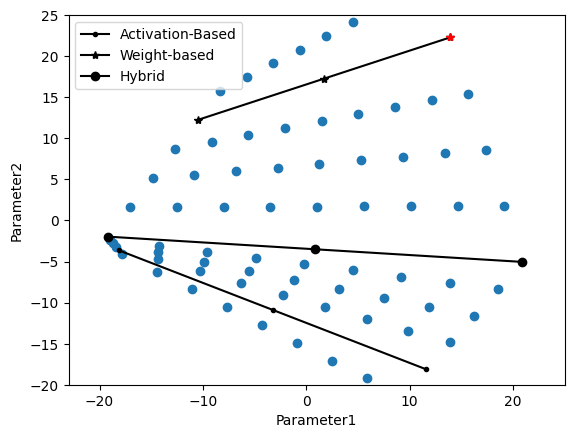

In [15]:
range_x = [-23, 25]
range_y = [-20, 25]
plt.figure()
# markers = [".","*","o","s","d"]
markers = [".","*","o"]
num_per_basin = len(avg_rates)
for i in range(3):
    plt.plot(coord[i*num_per_basin:(i+1)*num_per_basin, 0],
              coord[i*num_per_basin:(i+1)*num_per_basin, 1],
                marker=markers[i], 
                c="black")

i=1

reverse_vec = pca.inverse_transform(np.array([coord[i*num_per_basin:i*num_per_basin+1, 0].item(),
                                              coord[i*num_per_basin:i*num_per_basin+1, 1].item()]))

print(reverse_vec.shape)
point1 = pca.transform(reverse_vec.reshape(1,-1))
print(point1.shape)
plt.plot(point1[:,0],
              point1[:,1],
                marker=markers[i], 
                c="red")
plt.scatter(coord[9:,0],coord[9:,1])

plt.xlim(range_x)
plt.ylim(range_y)

plt.xlabel('Parameter1')
plt.ylabel('Parameter2')
# l = plt.legend(['Activation-Based', 'Weight-based', 'Hybrid1', 'Hybrid2', 'Hybrid3'])
l = plt.legend(['Activation-Based', 'Weight-based', 'Hybrid'])

In [16]:
def point_along_traj(mid, dx, dy):
    vec = matrix[mid] + dx*pc1 + dy*pc2
    xy = pca.transform(vec[None, :]).squeeze()
    
    vec = torch.from_numpy(vec).to(device)
    net = vec2net(vec)

    results = test_network(net)
    return xy[0], xy[1], results

def point_on_grid(point1):
    vec = pca.inverse_transform(point1)
    
    vec = torch.from_numpy(vec).to(device)
    net = vec2net(vec)

    results = test_network(net)
    return  results

## calc grid coord

In [17]:
mids = [item for item in range(0, 9)] # ids of models except ours-2
xx_lst = np.linspace(range_x[0], range_x[1], range_x[1]-range_x[0]+1).tolist()
yy_lst = np.linspace(range_y[0], range_y[1], range_y[1]-range_y[0]+1).tolist()
mids, xx_lst, yy_lst

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [-23.0,
  -22.0,
  -21.0,
  -20.0,
  -19.0,
  -18.0,
  -17.0,
  -16.0,
  -15.0,
  -14.0,
  -13.0,
  -12.0,
  -11.0,
  -10.0,
  -9.0,
  -8.0,
  -7.0,
  -6.0,
  -5.0,
  -4.0,
  -3.0,
  -2.0,
  -1.0,
  0.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0],
 [-20.0,
  -19.0,
  -18.0,
  -17.0,
  -16.0,
  -15.0,
  -14.0,
  -13.0,
  -12.0,
  -11.0,
  -10.0,
  -9.0,
  -8.0,
  -7.0,
  -6.0,
  -5.0,
  -4.0,
  -3.0,
  -2.0,
  -1.0,
  0.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0])

## along path

In [19]:
mids = []
tmp_lst = [x for x in range(matrix.shape[0])]
mids.extend(tmp_lst)

coord_lst = []
dx_lst = [-1, 0, 1] 
dy_lst = [-1, 0, 1]
for mid in tqdm(mids):
    for dx in dx_lst:
        for dy in dy_lst:
            xx, yy, results = point_along_traj(mid, dx, dy)
            coord_lst.append((xx, yy, results))
coord_lst

100%|██████████| 81/81 [20:07<00:00, 14.91s/it]


[(10.615869,
  -19.126413,
  {'loss1': 0.9799791514873505,
   'loss2': 0.11111131431534886,
   'acc1': 0.3612,
   'acc2': 0.9664}),
 (10.615874,
  -18.126404,
  {'loss1': 0.9849614828824997,
   'loss2': 0.1099677979014814,
   'acc1': 0.3619,
   'acc2': 0.966}),
 (10.615874,
  -17.126415,
  {'loss1': 0.9900764882564544,
   'loss2': 0.1092548075132072,
   'acc1': 0.3646,
   'acc2': 0.9663}),
 (11.615873,
  -19.126404,
  {'loss1': 0.9818003922700882,
   'loss2': 0.10706066442653536,
   'acc1': 0.3601,
   'acc2': 0.967}),
 (11.615868,
  -18.12641,
  {'loss1': 0.9867661535739899,
   'loss2': 0.10619326764717699,
   'acc1': 0.3628,
   'acc2': 0.9662}),
 (11.615875,
  -17.126406,
  {'loss1': 0.9919923335313797,
   'loss2': 0.10574946142733097,
   'acc1': 0.3648,
   'acc2': 0.9667}),
 (12.615872,
  -19.126406,
  {'loss1': 0.9837063610553741,
   'loss2': 0.10398561172187329,
   'acc1': 0.3606,
   'acc2': 0.967}),
 (12.615887,
  -18.126411,
  {'loss1': 0.9886276245117187,
   'loss2': 0.103257548

In [18]:
# suffix = "perm" if use_permute else "union"
# with open(f"save/mnist_coord_clip_{exp_idx}_{suffix}.pkl", 'wb') as f:
#     pkl.dump(coord_lst, f)

suffix = "perm" if use_permute else "union"
with open(f"save/mnist_coord_clip_{exp_idx}_{suffix}.pkl", 'rb') as f:
    coord_lst = pkl.load(f)

### interpolator

In [19]:
xi = np.linspace(range_x[0], range_x[1], 101)
yi = np.linspace(range_y[0], range_y[1], 101)
xi, yi

(array([-23.  , -22.52, -22.04, -21.56, -21.08, -20.6 , -20.12, -19.64,
        -19.16, -18.68, -18.2 , -17.72, -17.24, -16.76, -16.28, -15.8 ,
        -15.32, -14.84, -14.36, -13.88, -13.4 , -12.92, -12.44, -11.96,
        -11.48, -11.  , -10.52, -10.04,  -9.56,  -9.08,  -8.6 ,  -8.12,
         -7.64,  -7.16,  -6.68,  -6.2 ,  -5.72,  -5.24,  -4.76,  -4.28,
         -3.8 ,  -3.32,  -2.84,  -2.36,  -1.88,  -1.4 ,  -0.92,  -0.44,
          0.04,   0.52,   1.  ,   1.48,   1.96,   2.44,   2.92,   3.4 ,
          3.88,   4.36,   4.84,   5.32,   5.8 ,   6.28,   6.76,   7.24,
          7.72,   8.2 ,   8.68,   9.16,   9.64,  10.12,  10.6 ,  11.08,
         11.56,  12.04,  12.52,  13.  ,  13.48,  13.96,  14.44,  14.92,
         15.4 ,  15.88,  16.36,  16.84,  17.32,  17.8 ,  18.28,  18.76,
         19.24,  19.72,  20.2 ,  20.68,  21.16,  21.64,  22.12,  22.6 ,
         23.08,  23.56,  24.04,  24.52,  25.  ]),
 array([-20.  , -19.55, -19.1 , -18.65, -18.2 , -17.75, -17.3 , -16.85,
        -16.4 

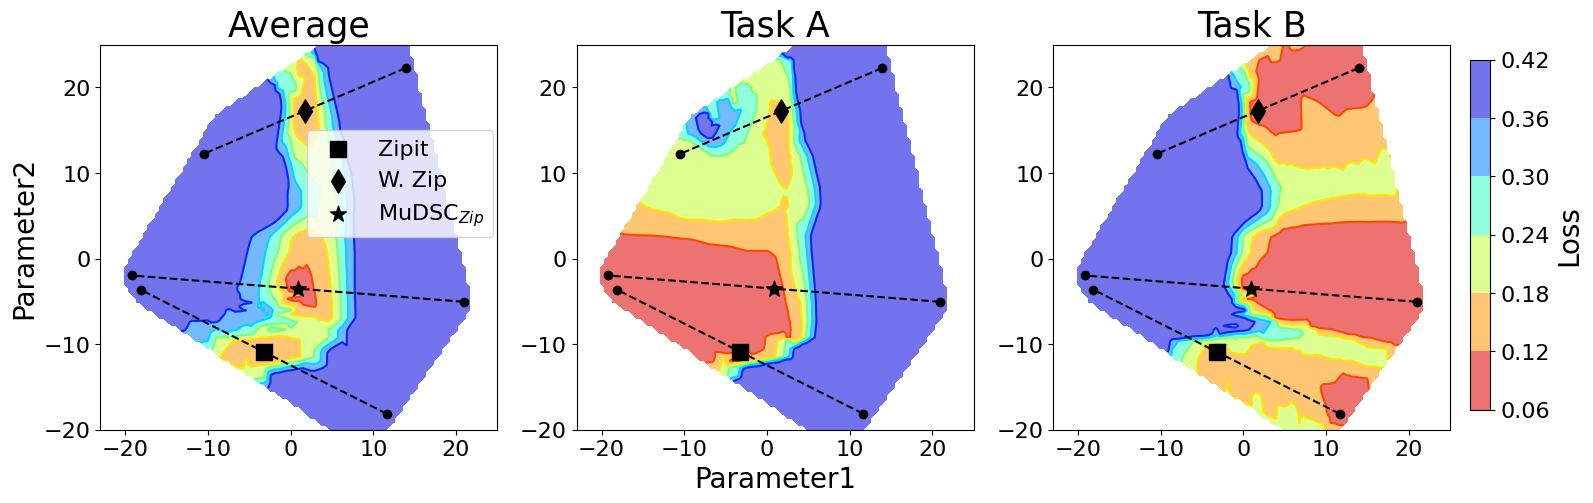

In [20]:
# x_inter = np.hstack([np.array(grid_xx), np.array(coord_xx)])
# y_inter = np.hstack([np.array(grid_yy),np.array(coord_yy)])
# z_inter = np.hstack([np.array(grid_loss), np.array(coord_loss)])
# x_inter = np.array(grid_xx)
# y_inter = np.array(grid_yy)
plt.rcParams[ 'text.usetex' ] = False
label = ['Zipit', 'W. Zip', r'MuDSC$_{Zip}$']
# z_inter = np.array(grid_loss)
title_fontsize=25
axis_fontsize=20
ticks_fontsize=16
legend_fontsize=16
coord_xx = [item[0] for item in coord_lst]
coord_yy = [item[1] for item in coord_lst]
coord_loss = [(item[2]["loss1"] + item[2]["loss2"])/2 for item in coord_lst]
coord_acc = [(item[2]["acc1"] + item[2]["acc2"])/2 for item in coord_lst]
coord_xx, coord_yy, coord_acc, coord_loss

x_inter = np.array(coord_xx)
y_inter = np.array(coord_yy)
z_inter = np.array(coord_loss)
interpolator = tri.LinearTriInterpolator(tri.Triangulation(x_inter, y_inter), z_inter)

xi = np.linspace(range_x[0], range_x[1], 101)
yi = np.linspace(range_y[0], range_y[1], 101)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
zi.min(), zi.max()

fig,ax = plt.subplots(1,3,figsize=(20,5))

cmap = plt.get_cmap("jet_r")
zi_ = np.copy(zi)
thres = 0.4
zi_[zi_>thres] = thres
plt.rcParams.update({'font.size': 14})
CS = ax[0].contour(xi, yi, zi_,5,zorder=1, cmap=cmap)
CF = ax[0].contourf(xi, yi, zi_,5, zorder=0, cmap=cmap,alpha=0.55)

markers = ["o","o","o"]
num_per_basin = 3
for i in range(3):
    ax[0].plot(coord[i*num_per_basin:(i+1)*num_per_basin, 0],
              coord[i*num_per_basin:(i+1)*num_per_basin, 1],
                marker=markers[i], 
                c="black",linestyle="--")
markers = ["s","d","*"]
for i in range(3):
    ax[0].scatter(coord[i*num_per_basin+1:i*num_per_basin+2, 0],
              coord[i*num_per_basin+1:i*num_per_basin+2, 1],
                marker=markers[i], 
                c="black",s=140,label=label[i],zorder=2)
ax[0].set_xlim(range_x)
ax[0].set_ylim(range_y)
ax[0].tick_params(axis='x', labelsize=ticks_fontsize)
ax[0].tick_params(axis='y', labelsize=ticks_fontsize)

# plt.xlabel('Parameter1')
ax[0].set_ylabel('Parameter2',fontsize=axis_fontsize)
ax[0].set_title('Average',fontsize=title_fontsize)
coord_xx = [item[0] for item in coord_lst]
coord_yy = [item[1] for item in coord_lst]
coord_loss = [item[2]["loss1"] for item in coord_lst]
coord_acc = [item[2]["acc1"] for item in coord_lst]
coord_xx, coord_yy, coord_acc, coord_loss

x_inter = np.array(coord_xx)
y_inter = np.array(coord_yy)
z_inter = np.array(coord_loss)
interpolator = tri.LinearTriInterpolator(tri.Triangulation(x_inter, y_inter), z_inter)

xi = np.linspace(range_x[0], range_x[1], 101)
yi = np.linspace(range_y[0], range_y[1], 101)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
zi.min(), zi.max()

cmap = plt.get_cmap("jet_r")
zi_ = np.copy(zi)
thres = 0.4
zi_[zi_>thres] = thres
# plt.rcParams.update({'font.size': 14})
CS = ax[1].contour(xi, yi, zi_,5,zorder=1, cmap=cmap)
CF = ax[1].contourf(xi, yi, zi_,5, zorder=0, cmap=cmap,alpha=0.55)
# plt.colorbar(CF, label='Loss', shrink=1.0)

markers = ["o","o","o"]
num_per_basin = 3
for i in range(3):
    ax[1].plot(coord[i*num_per_basin:(i+1)*num_per_basin, 0],
              coord[i*num_per_basin:(i+1)*num_per_basin, 1],
                marker=markers[i], 
                c="black",linestyle="--")
markers = ["s","d","*"]
for i in range(3):
    ax[1].scatter(coord[i*num_per_basin+1:i*num_per_basin+2, 0],
              coord[i*num_per_basin+1:i*num_per_basin+2, 1],
                marker=markers[i], 
                c="black",s=140,label=label[i],zorder=2)
ax[1].set_xlim(range_x)
ax[1].set_ylim(range_y)
ax[1].tick_params(axis='x', labelsize=ticks_fontsize)
ax[1].tick_params(axis='y', labelsize=ticks_fontsize)


ax[1].set_xlabel('Parameter1',fontsize=axis_fontsize)
ax[1].set_title('Task A',fontsize=title_fontsize)


coord_xx = [item[0] for item in coord_lst]
coord_yy = [item[1] for item in coord_lst]
coord_loss = [item[2]["loss2"] for item in coord_lst]
coord_acc = [item[2]["acc2"] for item in coord_lst]
# coord_loss = [item[2]["loss1"] for item in coord_lst]
# coord_acc = [item[2]["acc1"] for item in coord_lst]
coord_xx, coord_yy, coord_acc, coord_loss

x_inter = np.array(coord_xx)
y_inter = np.array(coord_yy)
z_inter = np.array(coord_loss)
interpolator = tri.LinearTriInterpolator(tri.Triangulation(x_inter, y_inter), z_inter)

xi = np.linspace(range_x[0], range_x[1], 101)
yi = np.linspace(range_y[0], range_y[1], 101)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
zi.min(), zi.max()

cmap = plt.get_cmap("jet_r")
zi_ = np.copy(zi)
thres = 0.4
zi_[zi_>thres] = thres
# plt.rcParams.update({'font.size': 14})
CS = ax[2].contour(xi, yi, zi_,5,zorder=1, cmap=cmap)
CF = ax[2].contourf(xi, yi, zi_,5, zorder=0, cmap=cmap,alpha=0.55)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])
cbar_ax.tick_params(labelsize=ticks_fontsize)
cbar =fig.colorbar(CF, shrink=1.0,cax=cbar_ax)
cbar.set_label('Loss', fontsize=axis_fontsize)


markers = ["o","o","o"]
num_per_basin = 3
for i in range(3):
    ax[2].plot(coord[i*num_per_basin:(i+1)*num_per_basin, 0],
              coord[i*num_per_basin:(i+1)*num_per_basin, 1],
                marker=markers[i], 
                c="black",linestyle="--")
markers = ["s","d","*"]
for i in range(3):
    ax[2].scatter(coord[i*num_per_basin+1:i*num_per_basin+2, 0],
              coord[i*num_per_basin+1:i*num_per_basin+2, 1],
                marker=markers[i], 
                c="black",s=140,label=label[i],zorder=2)
ax[2].set_xlim(range_x)
ax[2].set_ylim(range_y)
ax[2].tick_params(axis='x', labelsize=ticks_fontsize)
ax[2].tick_params(axis='y', labelsize=ticks_fontsize)

ax[2].set_title('Task B',fontsize=title_fontsize)
l = ax[0].legend(loc=(0.52,0.5),fontsize=legend_fontsize)

fig.savefig("loss_land.pdf",bbox_inches='tight')